* 25.10.2022
* Yaromir Kapustin
* v.01

В данной задаче нам представлены данные в которых ключевое поле — это то, просрочит ли клиент микро-финансовой организации выплату более чем на 60 дней или нет. 
Нам нужно построить модель, которая по входным данным предсказывала бы с максимальной точностью ключе-вой параметр. 
Основной параметр это delinq60plus. Остальные парамет-ры интуитивно понятны из таблиц.
#### Цель

Построить модель машинного обучения для предсказания вероятности того, что клиент уйдет в просрочку более 60 дней.

#### Задача
осуществить корректную загрузку данных
осуществить разведывательный анализ данных:
- разбить выборку на обучающую и тестовую
- проанализировать пропуски и решить, что с ними делать
- проанализировать выбросы
- создать/ удалить переменные
- закодировать категориальные переменные
- нормализовать числовые переменные (при необходимости)

построить модель и оценить ее качество
при необходимости вернуться к предыдущим шагам, чтобы улучшить качество модели


#### Высокая цель. Использовать (не везде, а где мы работаем с данными напрямую) SQL запросы. 
---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import sqlite3

In [3]:
conn = sqlite3.connect('test.db')
df = pd.read_csv(r'C:\Users\Yaromir\Desktop\MFOcredit.csv', sep=';')

In [180]:
df.head()

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1,03-Jan-2013,12-Jan-2013,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
1,2,03-Jan-2013,17-Jan-2013,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
2,3,03-Jan-2013,17-Jan-2013,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет
3,4,03-Jan-2013,17-Jan-2013,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
4,5,03-Jan-2013,17-Jan-2013,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,Нет


In [4]:
df.to_sql('MFOcredit', conn, index=False, if_exists='replace')

35212

In [5]:
def select(sql):
  return pd.read_sql(sql, conn)

## Чистка датасета

In [181]:
#часто встречается значение "Пропуск поля", заменю его на NaN. А также Да и Нет на 1 и 0
df.replace(to_replace = "Пропуск поля", value = np.nan, inplace=True)
df.replace(to_replace = "Нет", value = 0, inplace=True)
df.replace(to_replace = "Да", value = 1, inplace=True)

In [7]:
# вижу, что некоторые колонки содержат пропуски
sql = '''SELECT * FROM MFOcredit AS t'''
select(sql)

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1,03-Jan-2013,12-Jan-2013,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
1,2,03-Jan-2013,17-Jan-2013,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
2,3,03-Jan-2013,17-Jan-2013,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет
3,4,03-Jan-2013,17-Jan-2013,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
4,5,03-Jan-2013,17-Jan-2013,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,Нет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35207,35208,03-Jan-2014,17-Jan-2014,Мужской,30,Да,Долевая собственность,Гражданский брак/женат/замужем,Да,Официальное,Алтайский край,Да,Да,Нет
35208,35209,03-Jan-2014,17-Jan-2014,Женский,57,Нет,Собственное,Разведен,Да,Пропуск поля,Алтайский край,Да,Нет,Нет
35209,35210,03-Jan-2014,17-Jan-2014,Женский,38,Пропуск поля,Пропуск поля,Пропуск поля,Да,Пропуск поля,Новосибирская область,Нет,Да,Нет
35210,35211,03-Jan-2014,17-Jan-2014,Женский,19,Пропуск поля,Пропуск поля,Пропуск поля,Да,Пропуск поля,Кемеровская область юг,Нет,Нет,Нет


In [183]:
#повторяющихся строк нет
df.drop_duplicates()

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1,03-Jan-2013,12-Jan-2013,Мужской,44,0.0,Собственное,Гражданский брак/женат/замужем,0,Официальное,Новосибирская область,0.0,1.0,0
1,2,03-Jan-2013,17-Jan-2013,Мужской,21,NaN,Живут с родителями,Холост,0,Официальное,Кемеровская область юг,1.0,0.0,0
2,3,03-Jan-2013,17-Jan-2013,Мужской,25,NaN,Собственное,Холост,1,Официальное,Кемеровская область север,NaN,0.0,0
3,4,03-Jan-2013,17-Jan-2013,Женский,47,NaN,Собственное,Гражданский брак/женат/замужем,1,Официальное,Кемеровская область север,0.0,0.0,0
4,5,03-Jan-2013,17-Jan-2013,Мужской,22,0.0,Арендуемое,Гражданский брак/женат/замужем,0,Официальное,Кемеровская область север,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35207,35208,03-Jan-2014,17-Jan-2014,Мужской,30,1.0,Долевая собственность,Гражданский брак/женат/замужем,1,Официальное,Алтайский край,1.0,1.0,0
35208,35209,03-Jan-2014,17-Jan-2014,Женский,57,0.0,Собственное,Разведен,1,NaN,Алтайский край,1.0,0.0,0
35209,35210,03-Jan-2014,17-Jan-2014,Женский,38,NaN,NaN,NaN,1,NaN,Новосибирская область,0.0,1.0,0
35210,35211,03-Jan-2014,17-Jan-2014,Женский,19,NaN,NaN,NaN,1,NaN,Кемеровская область юг,0.0,0.0,0


In [184]:
#пропуски в %: auto 40%, housing 22%, marstatus 21%, jobtype 41%
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print(col, round(pct_missing*100))

id 0
date_start 0
date_end 0
gender 0
age 0
auto 40
housing 22
marstatus 21
regclient 0
jobtype 41
region 0
credits 3
children 2
delinq60plus 0


In [185]:
#удалю auto и jobtype, поскольки слишком много пропусков. Колонки неинформативны. А также колонку id
cols_to_drop = ["auto", "jobtype", "id"]
df = df.drop(cols_to_drop, axis=1)

In [186]:
#меняю формат даты
df['date_start'] = pd.to_datetime(df['date_start'], format="%d-%b-%Y")
df['date_end'] = pd.to_datetime(df['date_end'], format="%d-%b-%Y")

In [187]:
#datetime64[ns] to float
df[('date_start')] = df[('date_start')].values.astype("float64")
df[('date_end')] = df[('date_end')].values.astype("float64")

In [188]:
# заменяю пустые значения наиболее встречающимся
imputer = SimpleImputer(strategy='most_frequent')
df[['housing']] = imputer.fit_transform(df[['housing']])
df[['marstatus']] = imputer.fit_transform(df[['marstatus']])
df[['credits']] = imputer.fit_transform(df[['credits']])
df[['children']] = imputer.fit_transform(df[['children']])

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35212 entries, 0 to 35211
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date_start    35212 non-null  float64
 1   date_end      35212 non-null  float64
 2   gender        35212 non-null  object 
 3   age           35212 non-null  int64  
 4   housing       35212 non-null  object 
 5   marstatus     35212 non-null  object 
 6   regclient     35212 non-null  int64  
 7   region        35212 non-null  object 
 8   credits       35212 non-null  float64
 9   children      35212 non-null  float64
 10  delinq60plus  35212 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 3.0+ MB


<AxesSubplot:>

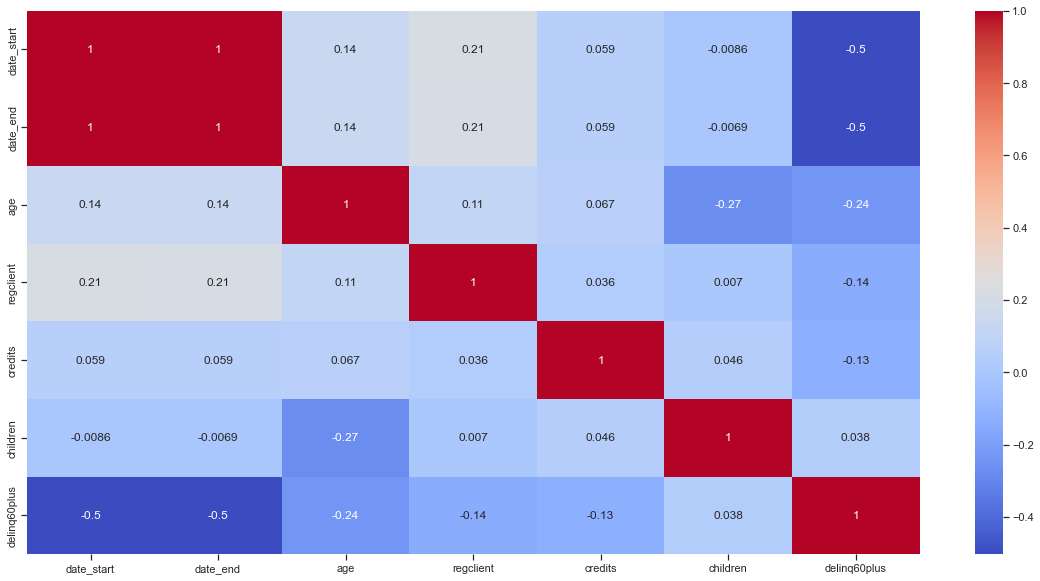

In [190]:
# есть небольшая обратная корреляция основного параматра с датами выдачи и погашения займа
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [191]:
# преобразую категориальные признаки
df = pd.concat([df, 
                      pd.get_dummies(df['housing'], prefix="housing"),
                      pd.get_dummies(df['marstatus'], prefix="marstatus"),
                      pd.get_dummies(df['gender'], prefix="gender"),
                      pd.get_dummies(df['region'], prefix="region")],
                     axis=1)

In [192]:
# удаляю лишние колонки
df.drop(['housing','marstatus','gender', 'region'], axis=1, inplace=True)

In [193]:
# Итоговый результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35212 entries, 0 to 35211
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   date_start                                35212 non-null  float64
 1   date_end                                  35212 non-null  float64
 2   age                                       35212 non-null  int64  
 3   regclient                                 35212 non-null  int64  
 4   credits                                   35212 non-null  float64
 5   children                                  35212 non-null  float64
 6   delinq60plus                              35212 non-null  int64  
 7   housing_Арендуемое                        35212 non-null  uint8  
 8   housing_Долевая собственность             35212 non-null  uint8  
 9   housing_Живут с родителями                35212 non-null  uint8  
 10  housing_Муниципальное             

## Нормализация

In [194]:
#разницы между MinMax и StandardScaler нету. AUC такой же
scaler = preprocessing.StandardScaler()

In [195]:
# нормализую даты и возраст
df[['date_start','date_end']] = scaler.fit_transform(df[['date_start','date_end']])
df[['age']] = scaler.fit_transform(df[['age']])

In [196]:
df

,date_start,date_end,age,regclient,credits,children,delinq60plus,housing_Арендуемое,housing_Долевая собственность,housing_Живут с родителями,...,marstatus_Гражданский брак/женат/замужем,marstatus_Разведен,marstatus_Холост,gender_Женский,gender_Мужской,region_Алтайский край,region_Кемеровская область север,region_Кемеровская область юг,region_Красноярский край,region_Новосибирская область
0,-2.110705,-2.179596,0.512484,0,0.0,1.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1,-2.110705,-2.130962,-1.232085,0,1.0,0.0,0,0,0,1,...,0,0,1,0,1,0,0,1,0,0
2,-2.110705,-2.130962,-0.928681,1,0.0,0.0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
3,-2.110705,-2.130962,0.740037,1,0.0,0.0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
4,-2.110705,-2.130962,-1.156234,0,1.0,1.0,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35207,1.414511,1.419323,-0.549427,1,1.0,1.0,0,0,1,0,...,1,0,0,0,1,1,0,0,0,0
35208,1.414511,1.419323,1.498545,1,1.0,0.0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0
35209,1.414511,1.419323,0.057379,1,0.0,1.0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
35210,1.414511,1.419323,-1.383786,1,0.0,0.0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0


## Построение модели

> RFC

In [216]:
y = df['delinq60plus']
x = df.drop(('delinq60plus'), axis=1)

In [217]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=21)

In [218]:
#подбор гиперпараметров
from sklearn.model_selection import GridSearchCV
parametrs = { 'n_estimators': range (10,51,10),
              'max_depth': range (1,13,2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid = GridSearchCV(rfc, parametrs).fit(x_train, y_train)
grid.best_params_

{'max_depth': 7,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 50}

In [214]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 50,  max_depth=9, min_samples_leaf=2, min_samples_split=8, random_state=42)
rfc.fit(x_train, y_train)
rfc.score(x_test, y_test)

0.770257478227944

In [215]:
y_pred = rfc.predict_proba(x_test)[:, 1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.8563868785697474

> CatBoostClassifier

In [170]:
from catboost import Pool, CatBoostClassifier

In [171]:
model = CatBoostClassifier(iterations=10,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass')

In [172]:
model.fit(x_train, y_train)
model.score(x_test, y_test)

0:	learn: 0.5210490	total: 2.58ms	remaining: 23.3ms
1:	learn: 0.4910333	total: 5.31ms	remaining: 21.2ms
2:	learn: 0.4693960	total: 7.68ms	remaining: 17.9ms
3:	learn: 0.4669633	total: 10.2ms	remaining: 15.3ms
4:	learn: 0.4584869	total: 12.6ms	remaining: 12.6ms
5:	learn: 0.4561415	total: 15ms	remaining: 9.97ms
6:	learn: 0.4515071	total: 17.4ms	remaining: 7.46ms
7:	learn: 0.4502040	total: 19.8ms	remaining: 4.96ms
8:	learn: 0.4497214	total: 22.1ms	remaining: 2.46ms
9:	learn: 0.4491387	total: 24.5ms	remaining: 0us


0.7659030670200682

In [173]:
y_pred = model.predict_proba(x_test)[:, 1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.8495880455093507